# Cross-Language Lexical and Syllabified Identity Analysis
This notebook computes lexical, syllable and tone identity across languages using wordlist template, syllabified wordlists, and tone patterns.

**Steps:**

Input:
1. Upload `wordlist.xlsx` (template containing only English column)
2. Upload `syllabified_output_result_updated.zip` (zipped Excel files per language with updated syllabified words)
3. Upload `structure_transformed_updated.zip` (zipped Excel files per language with structured version of updated syllabified words)
4. Upload `tone_labelling_output_result_updated.zip` (zipped Excel files per language with updated tone validation results)
5. Upload `Language_Profile_Wordlist_Updated.xlsx` (Updated language profile file)

Output:
6. Extract aligned transcriptions, syllabified forms (syllables and structured), and tone patterns
7. Compute identity matrices (Levenshtein) for lexical, syllabified, structured and tone forms
8. Visualize cross-linguistic variation using heatmaps

In [8]:
from google.colab import files
uploaded = files.upload()

Saving Language_Profile_Wordlist_Updated.xlsx to Language_Profile_Wordlist_Updated.xlsx


In [9]:
import pandas as pd
import numpy as np
import zipfile
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
!pip install python-Levenshtein
import Levenshtein
import os
import unicodedata

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 61.8 MB/s eta 0:00:00


In [10]:
# Extract syllabified files
zip_path_syll = 'syllabified_output_result_updated.zip'
extract_dir_syll = 'syllabified_extracted'
if not os.path.exists(extract_dir_syll):
    with zipfile.ZipFile(zip_path_syll, 'r') as zip_ref:
        zip_ref.extractall(extract_dir_syll)

# Extract syllable structure transformed files
zip_path_struct = 'structure_transformed_updated.zip'
extract_dir_struct = 'structure_transformed_extracted'
if not os.path.exists(extract_dir_struct):
    with zipfile.ZipFile(zip_path_struct, 'r') as zip_ref:
        zip_ref.extractall(extract_dir_struct)

# Extract tone-labelled files
zip_path_tone = 'tone_labelling_output_result_updated.zip'
extract_dir_tone = 'tone_extracted'
if not os.path.exists(extract_dir_tone):
    with zipfile.ZipFile(zip_path_tone, 'r') as zip_ref:
        zip_ref.extractall(extract_dir_tone)

In [11]:
# Extract wordlist from wordlist template
wordlist_df = pd.read_excel('wordlist.xlsx')
wordlist_df['English word'] = wordlist_df['English word'].astype(str).str.lower().str.replace(r'\(.*?\)', '', regex=True).str.strip()
base_english = wordlist_df[['English word']]

In [12]:
# Extract transcribed, syllabified, syllable structure transformed, and tone-labelled forms
transcribed_tables = {} # Dictionary to store transcribed words for each language
syllabified_tables = {} # Dictionary to store syllabified words for each language
structure_tables = {}  # Dictionary to store transformed syllables (NCV) for each language
tone_tables = {} # Dictionary to store tone labels for each language

# Load syllabified files
for file in Path(extract_dir_syll).glob('*.xlsx'):
    lang = file.stem
    df = pd.read_excel(file, dtype=str)

    if df.shape[1] >= 4:
        # Transcribed: column 2, Syllabified: column 4
        trans = df.iloc[:, [0, 1]].dropna().rename(columns={df.columns[0]: 'English word', df.columns[1]: lang})
        trans['English word'] = trans['English word'].str.lower().str.replace(r'\(.*?\)', '', regex=True).str.strip()
        transcribed_tables[lang] = trans

        syll = df.iloc[:, [0, 3]].dropna().rename(columns={df.columns[0]: 'English word', df.columns[3]: lang})
        syll['English word'] = syll['English word'].str.lower().str.replace(r'\(.*?\)', '', regex=True).str.strip()
        syllabified_tables[lang] = syll

# Load CV_Structure from syllable structure transformed files (extracting 5th column)
for file in Path(extract_dir_struct).glob('*.xlsx'):
    lang = file.stem  # Use the full stem as the language name directly
    df = pd.read_excel(file, dtype=str)

    if df.shape[1] >= 5:
        # Extract the 1st and 5th columns: English word and CV_Structure
        cv_struct = df.iloc[:, [0, 4]].dropna().rename(columns={
            df.columns[0]: 'English word',
            df.columns[4]: lang
        })
        # Clean up the English word entries
        cv_struct['English word'] = cv_struct['English word'].str.lower().str.replace(r'\(.*?\)', '', regex=True).str.strip()
        structure_tables[lang] = cv_struct

# Load tone-labelled files (extracting last column as tone component)
for file in Path(extract_dir_tone).glob('*.xlsx'):
    lang = file.stem
    df = pd.read_excel(file, dtype=str)
    if df.shape[1] >= 2:
        last_col_index = df.shape[1] - 1
        tone = df.iloc[:, [0, last_col_index]].dropna().rename(columns={df.columns[0]: 'English word', df.columns[last_col_index]: lang})
        tone['English word'] = tone['English word'].str.lower().str.replace(r'\(.*?\)', '', regex=True).str.strip()
        tone_tables[lang] = tone

In [13]:
# Align transcribed, syllabified, structured, and tone-labeled forms across languages
aligned_transcribed = base_english.copy()
aligned_syllabified = base_english.copy()
aligned_structure = base_english.copy()
aligned_tone = base_english.copy()

for lang in sorted(transcribed_tables):
    aligned_transcribed = aligned_transcribed.merge(transcribed_tables[lang], on='English word', how='left')

for lang in sorted(syllabified_tables):
    aligned_syllabified = aligned_syllabified.merge(syllabified_tables[lang], on='English word', how='left')

for lang in sorted(structure_tables):
    aligned_structure = aligned_structure.merge(structure_tables[lang], on='English word', how='left')

for lang in sorted(tone_tables):
    aligned_tone = aligned_tone.merge(tone_tables[lang], on='English word', how='left')

# Fill missing values with empty strings
aligned_transcribed.fillna('', inplace=True)
aligned_syllabified.fillna('', inplace=True)
aligned_structure
aligned_tone.fillna('', inplace=True)

In [14]:
# Lexical identity using Levenshtein
langs = aligned_transcribed.columns[1:]
def lexical_similarity(w1, w2):
    if not w1 and not w2: return 1.0
    if not w1 or not w2: return 0.0
    return 1 - Levenshtein.distance(w1, w2) / max(len(w1), len(w2))

lexical_matrix = pd.DataFrame(index=langs, columns=langs, dtype=float)
for i in langs:
    for j in langs:
        scores = [lexical_similarity(a, b) for a, b in zip(aligned_transcribed[i], aligned_transcribed[j]) if a and b]
        lexical_matrix.loc[i, j] = np.mean(scores) if scores else 0

In [15]:
# Define Levenshtein-based similarity function
def levenshtein_similarity(w1, w2):
    if not w1 and not w2: return 1.0
    if not w1 or not w2: return 0.0
    return 1 - Levenshtein.distance(w1, w2) / max(len(w1), len(w2))

# Compute the syllabified identity matrix using Levenshtein
langs_syll = aligned_syllabified.columns[1:]  # Skip 'English word' column
syll_matrix = pd.DataFrame(index=langs_syll, columns=langs_syll, dtype=float)

for i in langs_syll:
    for j in langs_syll:
        scores = [
            levenshtein_similarity(a, b)
            for a, b in zip(aligned_syllabified[i], aligned_syllabified[j])
            if a and b
        ]
        syll_matrix.loc[i, j] = np.mean(scores) if scores else 0.0

In [16]:
# Structure-transformed syllable identity using Levenshtein
langs = aligned_structure.columns[1:]  # skip 'English word' column

def structure_similarity(s1, s2):
    s1 = str(s1).strip()
    s2 = str(s2).strip()
    if not s1 and not s2:
        return 1.0
    if not s1 or not s2:
        return 0.0
    return 1 - Levenshtein.distance(s1, s2) / max(len(s1), len(s2))

structure_matrix = pd.DataFrame(index=langs, columns=langs, dtype=float)

for i in langs:
    for j in langs:
        scores = [
            structure_similarity(a, b)
            for a, b in zip(aligned_structure[i], aligned_structure[j])
            if pd.notna(a) and pd.notna(b)
        ]
        structure_matrix.loc[i, j] = np.mean(scores) if scores else 0

In [17]:
# Tone identity using Levenshtein
langs = aligned_tone.columns[1:]  # skip 'English word' column

def tone_similarity(t1, t2):
    if not t1 and not t2: return 1.0
    if not t1 or not t2: return 0.0
    return 1 - Levenshtein.distance(t1, t2) / max(len(t1), len(t2))

tone_matrix = pd.DataFrame(index=langs, columns=langs, dtype=float)
for i in langs:
    for j in langs:
        scores = [tone_similarity(a, b) for a, b in zip(aligned_tone[i], aligned_tone[j]) if a and b]
        tone_matrix.loc[i, j] = np.mean(scores) if scores else 0

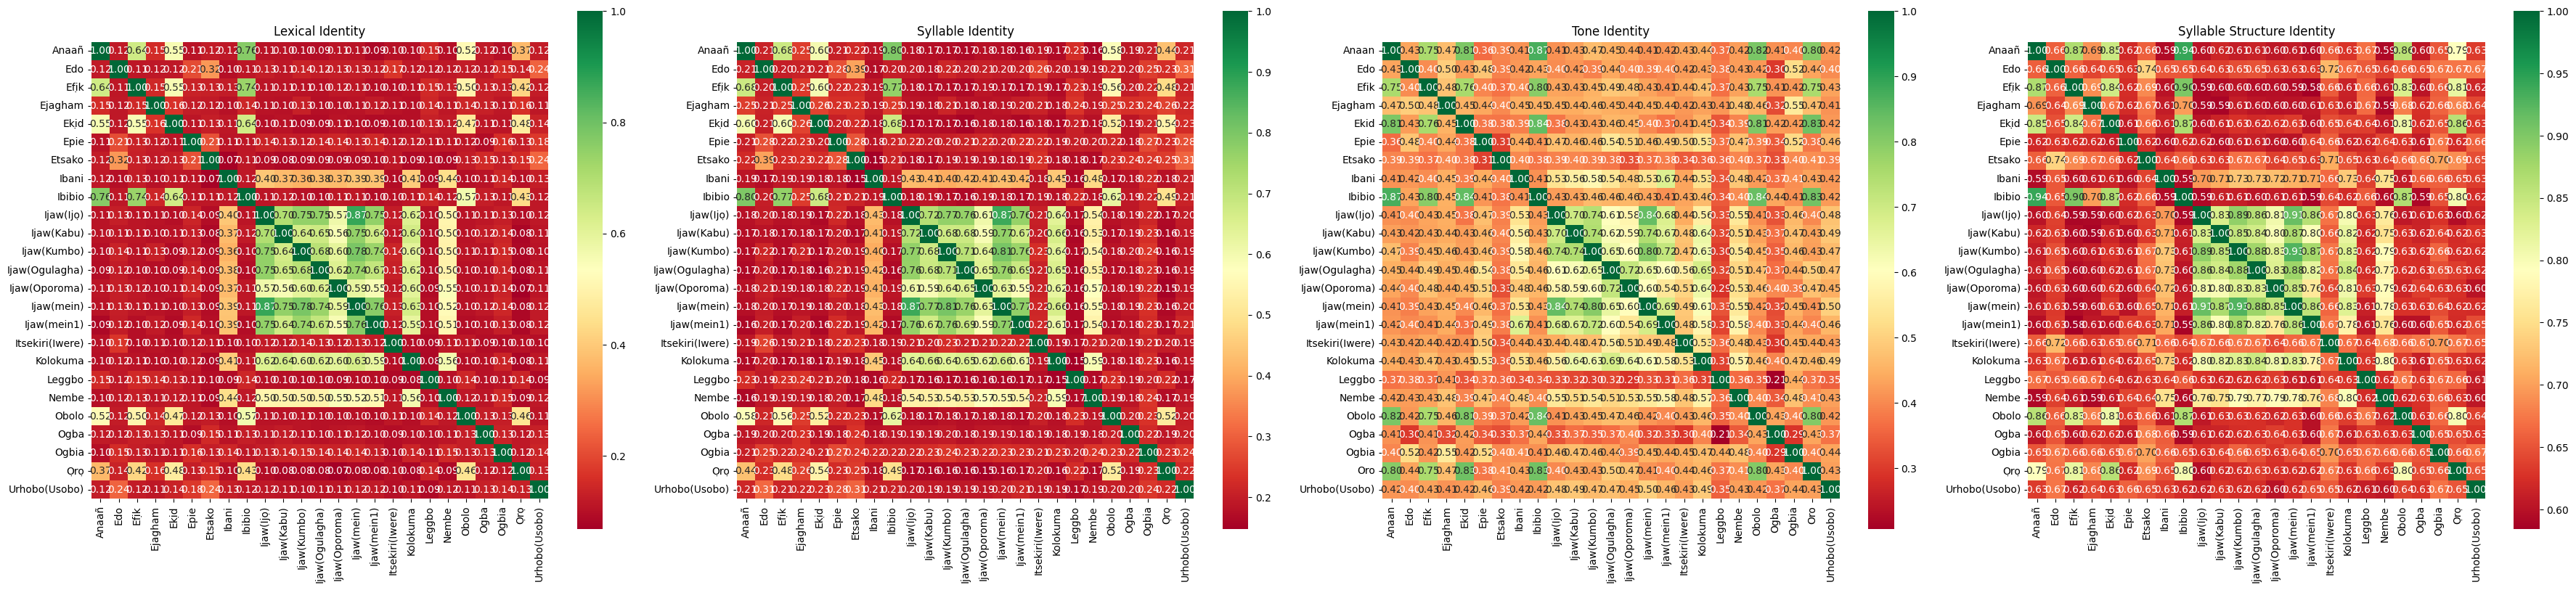

In [18]:
# Heatmaps
fig, ax = plt.subplots(1, 4, figsize=(36, 8))  # Increase number of subplots to 4

# Lexical Identity
sns.heatmap(lexical_matrix, annot=True, fmt='.2f', cmap='RdYlGn', ax=ax[0], square=True)
ax[0].set_title('Lexical Identity')

# Syllable Identity
sns.heatmap(syll_matrix, annot=True, fmt='.2f', cmap='RdYlGn', ax=ax[1], square=True)
ax[1].set_title('Syllable Identity')

# Structure-Transformed Identity
sns.heatmap(structure_matrix, annot=True, fmt='.2f', cmap='RdYlGn', ax=ax[3], square=True)
ax[3].set_title('Syllable Structure Identity')

# Tone Identity
sns.heatmap(tone_matrix, annot=True, fmt='.2f', cmap='RdYlGn', ax=ax[2], square=True)
ax[2].set_title('Tone Identity')

plt.tight_layout()
plt.show()

In [19]:
# Ensure all required variables exist
assert 'aligned_transcribed' in globals(), "aligned_transcribed not found"
assert 'aligned_syllabified' in globals(), "aligned_syllabified not found"
assert 'aligned_structure' in globals(), "aligned_structure not found"
assert 'aligned_tone' in globals(), "aligned_tone not found"
assert 'lexical_matrix' in globals(), "lexical_matrix not found"
assert 'syll_matrix' in globals(), "syll_matrix not found"
assert 'structure_matrix' in globals(), "structure_matrix not found"
assert 'tone_matrix' in globals(), "tone_matrix not found"

# Save aligned word tables
aligned_transcribed.to_excel("Aligned_Transcribed_Words_Languages.xlsx", index=False)
aligned_syllabified.to_excel("Aligned_Syllabified_Words_Languages.xlsx", index=False)
aligned_structure.to_excel("Aligned_Syllable_Structure_Languages.xlsx", index=False)
aligned_tone.to_excel("Aligned_Tone_Labels_Languages.xlsx", index=False)

# Save identity matrices
lexical_matrix.to_excel("Lexical_Identity_Matrix.xlsx")
syll_matrix.to_excel("Syllable_Identity_Matrix.xlsx")
structure_matrix.to_excel("Syllable_Structure_Identity_Matrix.xlsx")
tone_matrix.to_excel("Tone_Identity_Matrix.xlsx")

print("✅ All files successfully saved.")
print("✅ Included lexical, syllabification, tone, and syllable structure identity matrices.")

✅ All files successfully saved.
✅ Included lexical, syllabification, tone, and syllable structure identity matrices.


In [23]:
import pandas as pd
import os
import unicodedata
from pathlib import Path

# === File paths ===
wordlist_path = "wordlist.xlsx"
profile_path = "Language_Profile_Wordlist_Updated.xlsx"
syllabified_folder = "syllabified_extracted"
structure_folder = "structure_transformed_extracted"
tone_folder = "tone_extracted"

# === Load and normalize base wordlist ===
wordlist_df = pd.read_excel(wordlist_path)
wordlist_df.columns = [col.strip() for col in wordlist_df.columns]
wordlist_df["English word"] = wordlist_df["English word"].astype(str) \
    .str.lower() \
    .str.replace(r'\(.*?\)', '', regex=True) \
    .str.strip()

# === Initialize aligned tables ===
transcribed_aligned = wordlist_df.copy()
syllabified_aligned = wordlist_df.copy()
tone_aligned = wordlist_df.copy()
structure_aligned = wordlist_df.copy()

# === Load and normalize language profiles ===
profile_df = pd.read_excel(profile_path)
profile_df.columns = [col.strip().lower() for col in profile_df.columns]

# === Process syllabified files ===
for file in Path(syllabified_folder).glob("*.xlsx"):
    lang = file.stem
    df = pd.read_excel(file)
    df.columns = [col.strip().lower() for col in df.columns]

    if 'english word' not in df.columns or 'transcribed word' not in df.columns or 'syllabified word' not in df.columns:
        print(f"⚠️ Skipped {lang}: Required columns missing.")
        continue

    df['english word'] = df['english word'].astype(str) \
        .str.lower() \
        .str.replace(r'\(.*?\)', '', regex=True) \
        .str.strip()

    df['transcribed word'] = df['transcribed word'].astype(str).apply(
        lambda x: unicodedata.normalize('NFC', x.strip()))
    df['syllabified word'] = df['syllabified word'].astype(str).apply(
        lambda x: unicodedata.normalize('NFC', x.strip()))

    transcribed_map = dict(zip(df['english word'], df['transcribed word']))
    syllabified_map = dict(zip(df['english word'], df['syllabified word']))

    transcribed_aligned[lang] = transcribed_aligned["English word"].apply(lambda x: transcribed_map.get(x, ""))
    syllabified_aligned[lang] = syllabified_aligned["English word"].apply(lambda x: syllabified_map.get(x, ""))


# === Process structure-transformed syllable files ===
for file in Path(structure_folder).glob("*.xlsx"):
    lang = file.stem
    df = pd.read_excel(file)
    df.columns = [col.strip().lower() for col in df.columns]

    if 'english word' not in df.columns or 'cv_structure' not in df.columns:
        print(f"⚠️ Skipped {lang}: Required structure columns missing.")
        continue

    df['english word'] = df['english word'].astype(str) \
        .str.lower() \
        .str.replace(r'\(.*?\)', '', regex=True) \
        .str.strip()

    df['cv_structure'] = df['cv_structure'].astype(str).apply(
        lambda x: unicodedata.normalize('NFC', x.strip())
    )

    struct_map = dict(zip(df['english word'], df['cv_structure']))
    structure_aligned[lang] = structure_aligned["English word"].apply(
        lambda x: struct_map.get(x, "") if pd.notna(x) else ""
    )


# === Process tone-labelled files ===
for file in Path(tone_folder).glob("*.xlsx"):
    lang = file.stem
    df = pd.read_excel(file)
    df.columns = [col.strip().lower() for col in df.columns]

    if 'english word' not in df.columns or 'human-in-the-loop-validation' not in df.columns:
        print(f"⚠️ Skipped {lang}: Required tone columns missing.")
        continue

    df['english word'] = df['english word'].astype(str) \
        .str.lower() \
        .str.replace(r'\(.*?\)', '', regex=True) \
        .str.strip()

    df['human-in-the-loop-validation'] = df['human-in-the-loop-validation'].astype(str).apply(
        lambda x: unicodedata.normalize('NFC', x.strip())
    )

    tone_map = dict(zip(df['english word'], df['human-in-the-loop-validation']))
    tone_aligned[lang] = tone_aligned["English word"].apply(lambda x: tone_map.get(x, "") if pd.notna(x) else "")

print("✅ Transcribed, syllabified, tone and syllable structure aligned tables are generated.")

⚠️ Skipped Edo: Required structure columns missing.
⚠️ Skipped Ogba: Required structure columns missing.
⚠️ Skipped Ijaw(Ogulagha): Required structure columns missing.
⚠️ Skipped Ijaw(Kabu): Required structure columns missing.
⚠️ Skipped Etsako: Required structure columns missing.
⚠️ Skipped Leggbo: Required structure columns missing.
⚠️ Skipped Obolo: Required structure columns missing.
⚠️ Skipped Ibibio: Required structure columns missing.
⚠️ Skipped Ibani: Required structure columns missing.
⚠️ Skipped Epie: Required structure columns missing.
⚠️ Skipped Ijaw(Kumbo): Required structure columns missing.
⚠️ Skipped Ọrọ: Required structure columns missing.
⚠️ Skipped Ijaw(mein1): Required structure columns missing.
⚠️ Skipped Anaañ: Required structure columns missing.
⚠️ Skipped Efịk: Required structure columns missing.
⚠️ Skipped Ijaw(Ijọ): Required structure columns missing.
⚠️ Skipped Ogbia: Required structure columns missing.
⚠️ Skipped Ejagham: Required structure columns missi